In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import numpy as np
import pandas as pd
from stochastic_rnn import StochasticLSTM
from variational_module import MCSingleMixin
from train_utils import train_model, BCLogitMetric

In [2]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, accuracy_score, recall_score

In [3]:
from classification_uncertainty_utils import aleatoric_uncertainty, epistemic_uncertainty, uncertainty_avg, score_avg

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
np.random.seed(1234)
torch.manual_seed(1234)

In [6]:
training_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Training.data", sep=',', dtype=np.float32)
testing_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Testing.data", sep=',', dtype=np.float32)

In [7]:
dim = 1
seq_length = 100
DROP = 0.5

In [8]:
x_train = minmax_scale(training_table.drop("class", axis=1).values, axis=1)
y_train = training_table["class"].values
x_test = minmax_scale(testing_table.drop("class", axis=1).values, axis=1)
y_test = testing_table["class"].values

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

N = len(y_train)

train_dl = torch.utils.data.DataLoader(
        [(x_train[i], y_train[i]) for i in range(len(y_train))],
        batch_size=10,
        shuffle=True
)
val_dl = torch.utils.data.DataLoader(
        [(x_val[i], y_val[i]) for i in range(len(y_val))],
        batch_size=10,
        shuffle=False
)
test_dl = torch.utils.data.DataLoader(
        [(x_test[i], y_test[i]) for i in range(len(y_test))],
        batch_size=len(y_test),
        shuffle=False
)

In [9]:
class Net(nn.Module, MCSingleMixin):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = StochasticLSTM(1, 10, DROP)
        self.fc = nn.Linear(10, 1)

    def regularizer(self):        
        # Weight and bias regularizer
        weight_sum, bias_sum, dropout_reg = self.rnn.regularizer()
        
        return weight_sum + bias_sum + dropout_reg
    
    def get_output_shape(self, x: torch.Tensor):
        B = x.shape[1]
        return (B,)

    def forward(self, x: torch.Tensor):
        out, _ = self.rnn(x)
        out = out[-1]
        out = torch.relu(out)
        out = self.fc(out).flatten()
        return out

In [10]:
net = Net()
criterion = nn.BCEWithLogitsLoss()

optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [11]:
metrics = [BCLogitMetric()]

In [12]:
%%time
net = train_model(net, train_dl, val_dl, criterion, optimizer, "hill-valley-0.5.pt", 100, metrics=metrics, patience=5)

[1, 100.00%] train loss: 0.698799
[1, 100.00%] validate loss: 0.711887
Accuracy = 0.533
[2, 100.00%] train loss: 0.682905
[2, 100.00%] validate loss: 0.688852
Accuracy = 0.712
[3, 100.00%] train loss: 0.633740
[3, 100.00%] validate loss: 0.619421
Accuracy = 0.771
[4, 100.00%] train loss: 0.548805
[4, 100.00%] validate loss: 0.537875
Accuracy = 0.816
[5, 100.00%] train loss: 0.481695
[5, 100.00%] validate loss: 0.460680
Accuracy = 0.845
[6, 100.00%] train loss: 0.415644
[6, 100.00%] validate loss: 0.404528
Accuracy = 0.864
[7, 100.00%] train loss: 0.380502
[7, 100.00%] validate loss: 0.366852
Accuracy = 0.877
[8, 100.00%] train loss: 0.341207
[8, 100.00%] validate loss: 0.315712
Accuracy = 0.891
[9, 100.00%] train loss: 0.272960
[9, 100.00%] validate loss: 0.289936
Accuracy = 0.900
[10, 100.00%] train loss: 0.252959
[10, 100.00%] validate loss: 0.258560
Accuracy = 0.908
[11, 100.00%] train loss: 0.233153
[11, 100.00%] validate loss: 0.239731
Accuracy = 0.915
[12, 100.00%] train loss: 0.

### Test

In [13]:
net.eval()
with torch.no_grad():
    for i, (x, y) in enumerate(test_dl):
        pre_sigmoids = net.sample(10, x.transpose(-2,-3))
        scores = torch.sigmoid(pre_sigmoids)
        score_average = score_avg(scores)
        predictions = torch.round(score_average)
        uncertainties = uncertainty_avg(scores)
        print("Accuracy = %.2f" % accuracy_score(y, predictions))
        print("Precision = %.2f" % precision_score(y, predictions))
        print("AUCROC = %.2f" % roc_auc_score(y, score_average))

Accuracy = 1.00
Precision = 1.00
AUCROC = 1.00


In [14]:
A = aleatoric_uncertainty(scores)
E = epistemic_uncertainty(scores)

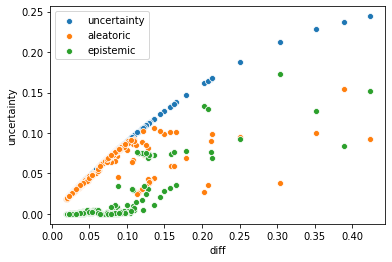

In [16]:
dist = torch.abs(y - score_average)
sns.scatterplot(x=dist, y=uncertainties)
sns.scatterplot(x=dist, y=A)
sns.scatterplot(x=dist, y=E)
plt.xlabel("diff")
plt.ylabel("uncertainty")
plt.legend(labels=['uncertainty', 'aleatoric', 'epistemic'])

### Spread pre and post sigmoid analysis

In [18]:
T, B = pre_sigmoids.shape
pre_sigmoid_df = pd.DataFrame(columns=["entry","value"])
post_sigmoid_df = pd.DataFrame(columns=["entry","value"])
for i in range(T):
    for j in range(20):
        pre_sigmoid_df.loc[i*B + j] = (j+1, pre_sigmoids[i,j])
        post_sigmoid_df.loc[i*B + j] = (j+1, scores[i,j])

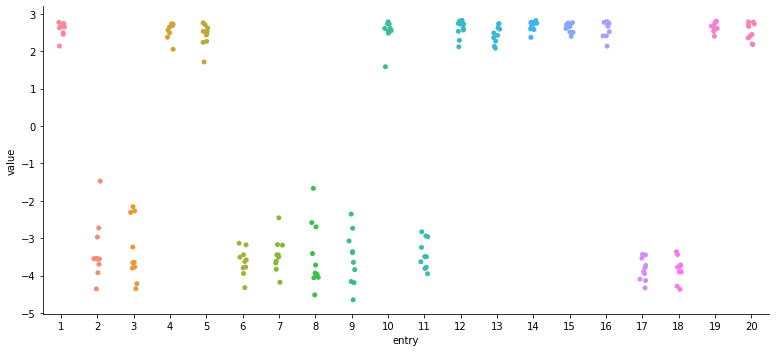

In [19]:
plot = sns.catplot(x="entry", y="value", data=pre_sigmoid_df)
plot.fig.set_figwidth(12)

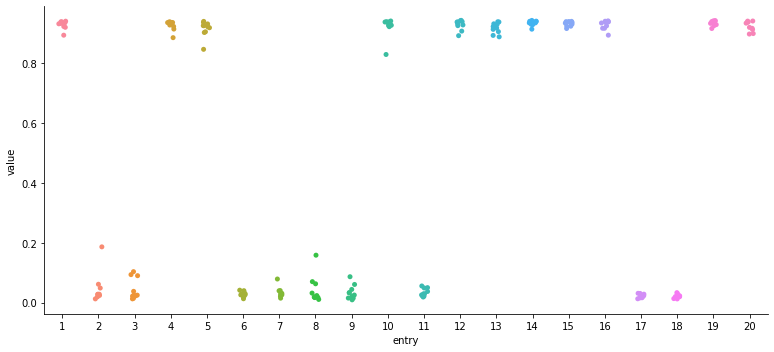

In [20]:
plot = sns.catplot(x="entry", y="value", data=post_sigmoid_df)
plot.fig.set_figwidth(12)

### Flat line test

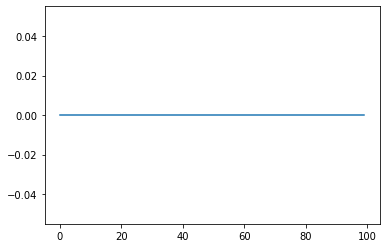

predictions tensor([0.9308, 0.9284])
uncertainties tensor([0.0644, 0.0665])


In [21]:
new_x_test = minmax_scale(np.full((2, 100), 0., dtype=np.float32), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

net.eval()
with torch.no_grad():
    outputs = net.sample(10, new_x_test)
    outputs = torch.sigmoid(outputs)
    uncertainties = uncertainty_avg(outputs)
    scores = score_avg(outputs)

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", scores)
print("uncertainties", uncertainties)

### Noise test

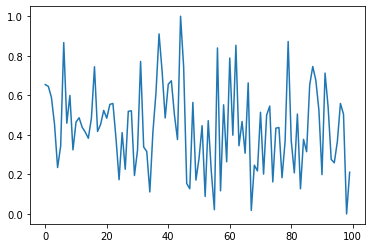

predictions tensor([0.5574, 0.6510])
uncertainties tensor([0.2467, 0.2272])


In [22]:
new_x_test = minmax_scale(np.random.randn(2, 100).astype(np.float32), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

net.eval()
with torch.no_grad():
    outputs = net.sample(10, new_x_test)
    outputs = torch.sigmoid(outputs)
    uncertainties = uncertainty_avg(outputs)
    scores = score_avg(outputs)

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", scores)
print("uncertainties", uncertainties)

### Note
In binary classification, the maximum uncertainty is 0.25 (need to verify this), and the minimum is 0.